In [295]:
 #main script

In [310]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lstm as lstm
import preprocess as pp
import os

In [311]:
np.random.seed(0)

#Check data file
dataset_dir = os.path.join(os.getcwd(), 'data')
index = 'GE.csv'
assert index in os.listdir(dataset_dir)

In [312]:
#Import data 
ls = os.listdir(dataset_dir)
for i in ls:
    if i == index:
        dataset = pd.read_csv(os.path.join(dataset_dir, i), usecols=[1,2,3,4])

dataset = dataset.reindex(index = dataset.index[::-1])
dataset.head(10)

,Open,High,Low,Close
3999,41.00,41.90,40.41,41.53
3998,41.52,41.83,40.40,40.47
3997,40.55,41.30,40.29,40.85
3996,40.90,41.31,40.61,41.04
3995,41.10,42.26,41.01,41.99
3994,42.00,42.56,41.65,42.17
3993,42.25,42.30,41.15,41.23
3992,41.65,41.65,40.60,40.61
3991,40.70,41.50,39.84,40.20
3990,40.15,41.20,40.07,40.98


In [313]:
#Select indicators
OHLC_avg = pp.select_fields(dataset, ['Open', 'High', 'Low', 'Close']) 
HLC_avg = pp.select_fields(dataset, ['High', 'Low', 'Close'])
close = dataset[['Close']]

In [314]:
counter = np.arange(1, len(dataset) + 1, 1)

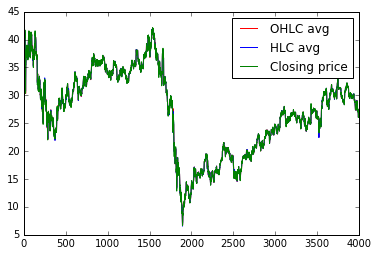

In [315]:
plt.plot(counter, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(counter, HLC_avg, 'b', label = 'HLC avg')
plt.plot(counter, close, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')

plt.show()

In [316]:
OHLC_avg = pp.normalize(OHLC_avg)

[[0.97497703]
 [0.97059447]
 [0.96190005]
 ...
 [0.56110836]
 [0.5640065 ]
 [0.56718739]]


In [317]:
# TRAIN-TEST SPLIT
train, test = pp.split(OHLC_avg, 0.75)

train


array([[0.97497703],
       [0.97059447],
       [0.96190005],
       ...,
       [0.51021418],
       [0.50823496],
       [0.50611437]])

In [318]:
def preprocess(dataset, step): 
	x, y = [], []
	for i in range(len(dataset)-step):
		tmp = dataset[i:(i+step),0]
		x.append(tmp)
		y.append(dataset[i + step, 0])
	
	return np.array(x), np.array(y)


#time step 1
trainX, trainY = preprocess(train, 1)
testX, testY = preprocess(test, 1)

trainX.shape, trainY.shape

((2999, 1), (2999,))

In [319]:
#reshape X inputs must be of dim 3
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

step_size = 1

trainX.shape, testX.shape



((2999, 1, 1), (999, 1, 1))

In [320]:
#Training
lstm.model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
 - 19s - loss: 1.2607e-04
Epoch 2/5
 - 19s - loss: 1.2518e-04
Epoch 3/5
 - 18s - loss: 1.2607e-04
Epoch 4/5
 - 17s - loss: 1.2595e-04
Epoch 5/5
 - 17s - loss: 1.2595e-04


In [321]:
#Predicted results are normalized values 
trainPredict = lstm.model.predict(trainX)
testPredict = lstm.model.predict(testX)

denormalized_trainPredict = scaler.inverse_transform(trainPredict)
denormalized_testPredict = scaler.inverse_transform(testPredict)
print denormalized_trainPredict.shape, denormalized_testPredict.shape

denormalized_trainY = scaler.inverse_transform([trainY])
denormalized_testY = scaler.inverse_transform([testY]) 
print denormalized_trainY.shape, denormalized_testY.shape


(2999, 1) (999, 1)
(1, 2999) (1, 999)


In [322]:

#Evaluate model
trainScore = math.sqrt(mean_squared_error(denormalized_trainY[0], denormalized_trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(denormalized_testY[0], denormalized_testPredict[:,0]))

print('Score: Training RMSE: %.4f' % (trainScore))
print('Score: Testing RMSE: %.4f' % (testScore))



Score: Training RMSE: 0.3934
Score: Testing RMSE: 0.2643


(2999, 1) (999, 1)


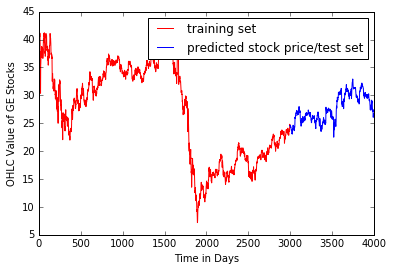

In [374]:
#Checking shape to plot training/testing data 
print denormalized_trainPredict.shape, denormalized_testPredict.shape

#Same dataset for plotting 3 types of info 

#Training 0-2999
p1 = np.empty_like(OHLC_avg)
p1[:, :] = np.nan
p1[0:len(denormalized_trainPredict)] = denormalized_trainPredict  

#Testing 3000-3999
p2 = np.empty_like(OHLC_avg)
p2[:, :] = np.nan
p2[len(denormalized_trainPredict): len(OHLC_avg)-1-step_size, :] \
                = denormalized_testPredict

    
#Denormalize main OHLC  
OHLC_avg = scaler.inverse_transform(OHLC_avg)


# plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(p1, 'r', label = 'training set')
plt.plot(p2, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of GE Stocks')
plt.show()


In [386]:
#Predict next day stock value
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = lstm.model.predict(np.reshape(last_val_scaled, (1,1,1)))
# print np.append(last_val, next_val) 
last, next = np.asscalar(last_val), np.asscalar(last_val*next_val)
diff = (next - last)/last*100
print("Last Day Value: %.4f" % last) 
print("Next Day Value: %.4f" % next) 
print("Value Difference: %.4f" % diff + "%" ) 

Last Day Value: 0.5643
Next Day Value: 0.5612
Value Difference: -0.5501%
